In [1]:
# Modif target_binary, ignore_column for next participant ????????????????????????????
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT'
trial_info_file = '/A0_kabir/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/A0_kabir/Experimental/data.mat'
epoch_file = '/my_code/epochs_from_matrix/epochs_0.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']
electrodes_kabir = ['POz', 'PO3', 'PO4', 'Pz', 'P1', 'P3', 'Oz', 'O1', 'O2']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy


In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']


In [4]:
# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_8437/4056453725.py:18: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [5]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


In [6]:
# Keep only trials where there was no target
epochs = epochs['target_binary==0']

# A. Frequency tagging condition
# 1 - Tag presence
## 1.1 FFT & SNR

In [7]:
epochs_freqtag = epochs['tagging_type==0'].copy()

In [8]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0
sfreq = epochs_freqtag.info["sfreq"]

# Spectrum of the signal averaged over trials
spectrum = epochs_freqtag.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs_psd = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999)) (?? voir tuto pour explications, on ignore les bandes les plus proches car la fenetre target est tres etroite ?)

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get SNR on all frequency ranges, excluding close neighbors (±2Hz) from regularizing points (ask how many nei in original paper??
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((2 - bin_size/2)//bin_size)

snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)


/tmp/ipykernel_8437/1594341003.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


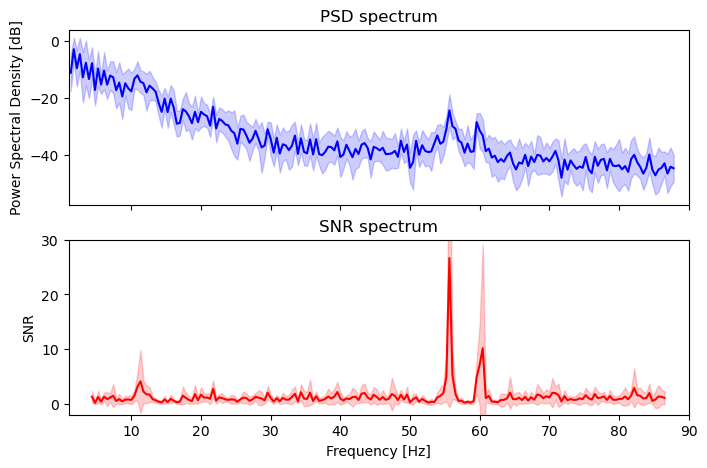

In [9]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [10]:
# Extract SNR values at the stimulation frequency --- ??? a corriger + ?en fun du cued
stim_freq1 = 55.5
stim_freq2 = 60

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


SNR at 55.5Hz: 26.641490773859974
SNR at 60Hz: 7.185293748601227


In [11]:
# Simplify metadata
epochs_freqtag.metadata['flicker_sides'] = epochs_freqtag.metadata['flicker_sides'].replace({0: 6056, 1: 5660})
epochs_freqtag.metadata['cued_side'] = epochs_freqtag.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'left')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'right')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'left'))
epochs_freqtag.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 56, np.nan))

## 1.2 Topography of the SNR

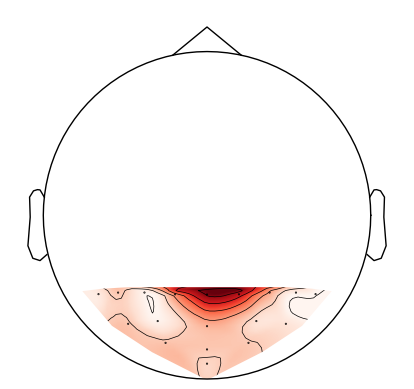

/tmp/ipykernel_8437/2059831999.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


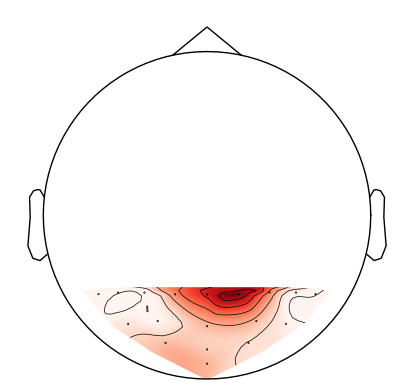

/tmp/ipykernel_8437/2059831999.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

In [13]:
# Channels with the highest SNR 
print(f'Channels with highest SNR for 56Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]}')
print(f'Channels with highest SNR for 60Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:4]}')

Channels with highest SNR for 56Hz['Pz' 'P2' 'P1' 'P4']
Channels with highest SNR for 60Hz['P2' 'Pz' 'P4' 'P1']


In [14]:
SNR_best_electrodes = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [15]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

### Coherence with Hilbert transform

In [16]:
def coherence_kabir(signalX, pick, freq_of_interest):

    #get info from EEG
    min_time = signalX.times[0]
    max_time = signalX.times[-1]
    sampling_rate = signalX.info['sfreq']
    
    # Band-pass EEG (+/-1.9Hz) and apply hilbert
    signalXh = signalX.copy().pick(pick).filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=False).apply_hilbert()
    signalXh = np.squeeze(signalXh.get_data(copy=False)).T
    n = signalXh.shape[1]  # number of trials

    #Create sine wave
    t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
    signalY = np.sin(2 * np.pi * freq_of_interest * t)
    signalY = np.tile(signalY, (n,1)).T #repeat over trials
    # Hilbert transform
    signalYh = scipy.signal.hilbert(signalY.T, axis=1)

    # Magnitude
    mX = np.abs(signalXh).T
    mY = np.abs(signalYh)

    # Phase difference
    phase_diff = np.angle(signalXh).T - np.angle(signalYh)

    coh = np.zeros(signalY.shape[0])
    for t in range(signalY.shape[0]):
        num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
        denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
        coh[t] = num/denom
        
    return coh

channels = epochs_freqtag.info['ch_names']

epochs_freqtag_cropped = epochs_freqtag.copy().crop(tmin, tmax)

coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_freqtag_cropped.times)))

for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_freqtag_cropped, [channel], freq)

coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_freqtag_cropped.info, np.array([coherence_mat]), epochs_freqtag_cropped.times, freqs)

# Baseline (-1 to 0s) correction
coherence_hilbert = coherence_hilbert.apply_baseline(baseline=(tmin, 0))

Applying baseline correction (mode: mean)


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


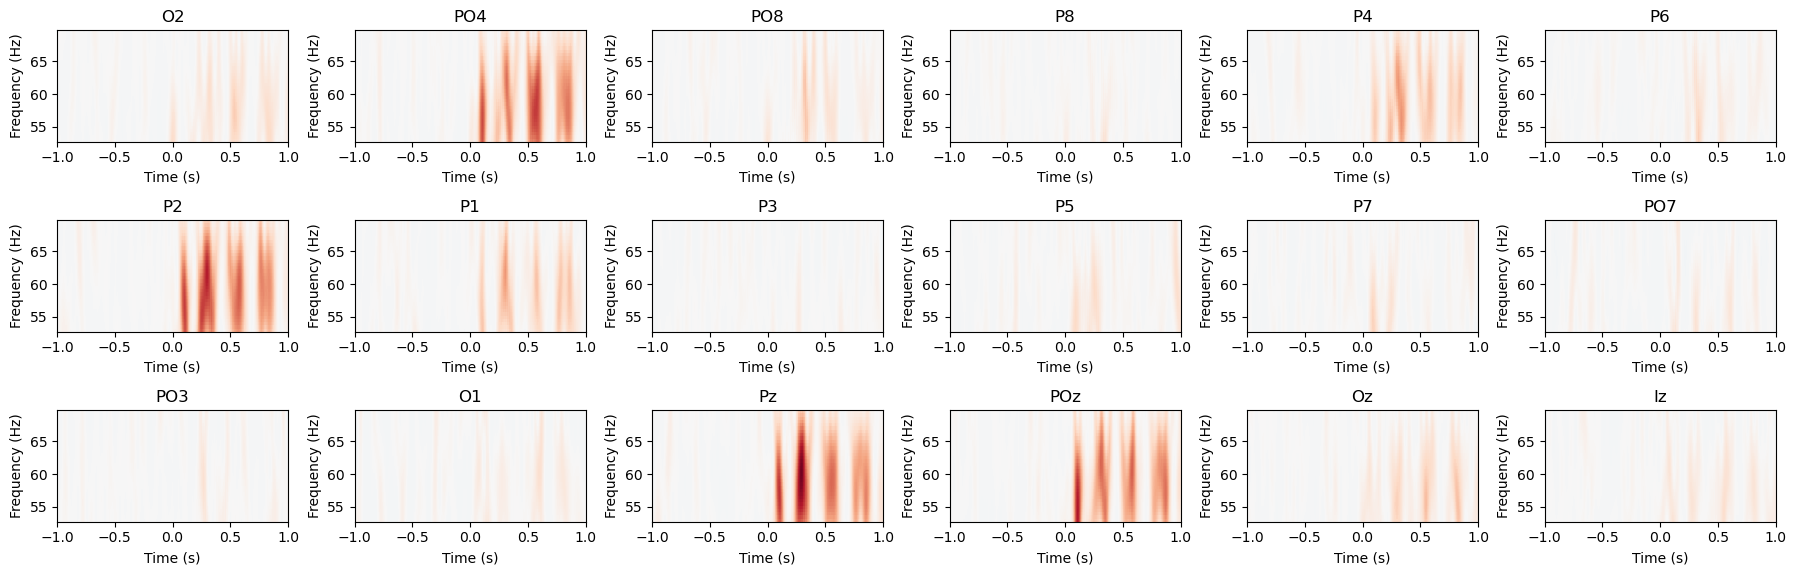

In [17]:
fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
axes = axes.flatten() 

# Plot each channel
for e, (channel, ax) in enumerate(zip(channels, axes)):
    coherence_hilbert.plot(
        [e],
        baseline= None,
        vlim=(-.3, .3),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel)  

plt.tight_layout()
plt.show()

### Coherence with Morlet estimation across all no target trials

In [18]:
# Get inter-trial coherence (from a Morlet time-frequency estimation)
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

_, itc = epochs_freqtag.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs, return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc = itc.apply_baseline(baseline=(tmin, 0))

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   14.6s


Applying baseline correction (mode: mean)


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


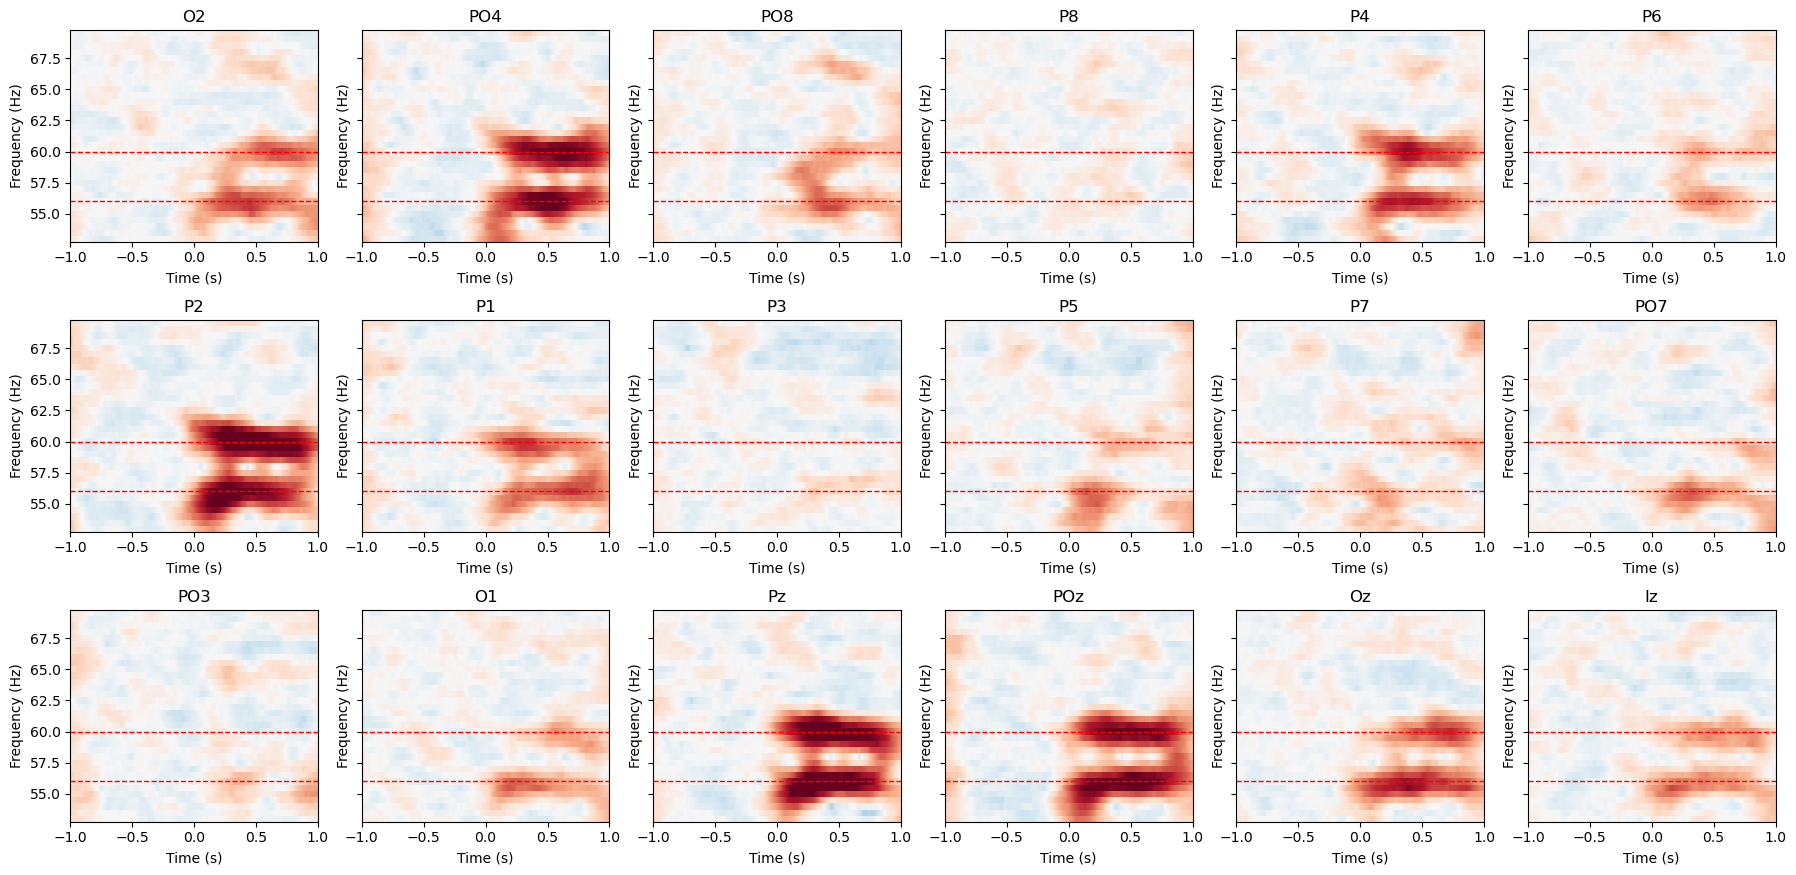

In [19]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

# Plot each electrode
for e, (elec, ax) in enumerate(zip(epochs_freqtag.info['ch_names'], axes)):
    itc.plot(
        picks=[elec],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(elec) 
    ax.axhline(y=56, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [20]:
# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc.get_data(return_freqs=True)
print(f'Frequencies with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')

Frequencies with the maximum coherence in descending order : [56.  55.5 60.  56.5]


### Select electrodes based on coherence (across trials of a same cued frequency)

In [21]:
# Get inter-trial coherence with 56 and 60Hz by cued frequency 
freqs5660 = [56, 60]
_, itc_60 = epochs_freqtag['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs5660, n_cycles=np.array(freqs5660)/2, return_itc=True, average=True
)
# Baseline (-1 to 0s) correction
itc_60 = itc_60.apply_baseline(baseline=(-1, 0 ))

_, itc_56 = epochs_freqtag['cued_tag == 56'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs5660, n_cycles=np.array(freqs5660)/2, return_itc=True, average=True
)
# Baseline (-1 to 0s) correction
itc_56 = itc_56.apply_baseline(baseline=(-1, 0 ))

itc_60_arr, times_coh, freqs_idx = itc_60.get_data(return_freqs = True, return_times = True)
itc_56_arr = itc_56.get_data()
freqs_idx

Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


array([56., 60.])

In [22]:
# Channels with the highest coherence with the cued frequency
print(f'From best to 4th \nChannels with the highest coherence with 60 when 60 was cued:{np.array(epochs.info['ch_names'])[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1]][:4]} \
                        \nChannels with the highest coherence with 56 when 56 was cued:{np.array(epochs.info['ch_names'])[np.argsort(itc_56_arr[:,0,:].max(axis = 1))[::-1]][:4]}')

From best to 4th 
Channels with the highest coherence with 60 when 60 was cued:['P2' 'PO4' 'Pz' 'POz']                         
Channels with the highest coherence with 56 when 56 was cued:['Pz' 'PO4' 'P2' 'POz']


In [23]:
best_electrodes_coherence = np.array(epochs.info['ch_names'])[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1]][:4]

# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

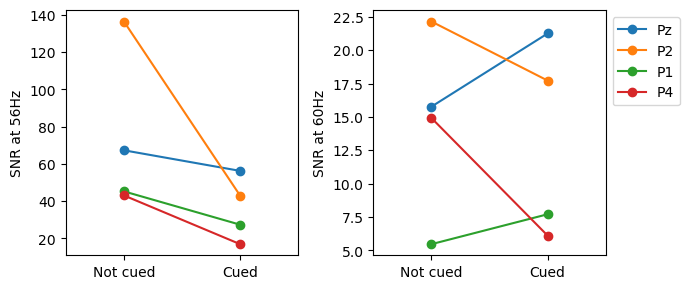

In [24]:
queries = ["cued_tag == 60", "cued_tag == 56"]
vals = {}
stim_freq1 = 55.5
stim_freq2 = 60.5

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick(SNR_best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="boxcar",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    bin_size = np.diff(freqs_psd)[0]
    skip_nei = int((2 - bin_size/2)//bin_size)
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=2, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[query] = snrs[:, [i_bin_1,i_bin_2]]

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(SNR_best_electrodes):
    ax[0].plot([0,1], [vals['cued_tag == 60'][e,0], vals['cued_tag == 56'][e,0]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['cued_tag == 60'][e,1], vals['cued_tag == 56'][e,1]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

### Comparing Morlet coherence across cued conditions

In [25]:
coherence_with60_for60cued_top4ch = itc_60_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],1,:]
coherence_with60_for56cued_top4ch = itc_60_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],0,:]
coherence_with56_for60cued_top4ch = itc_56_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],1,:]
coherence_with56_for56cued_top4ch = itc_56_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],0,:]

Text(0, 0.5, 'Coherence contrast cued/uncued')

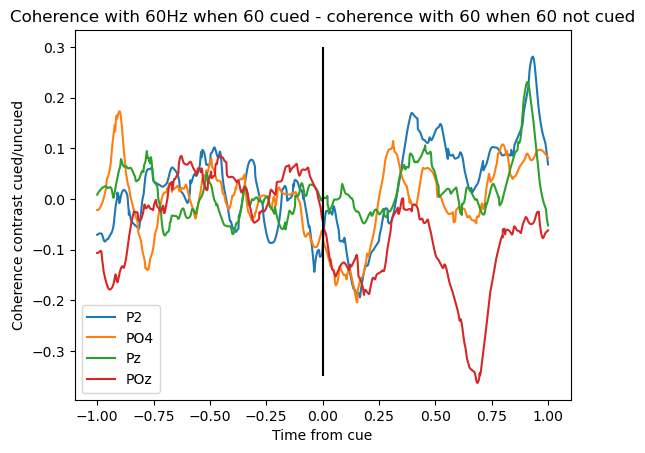

In [26]:
plt.plot(times_coh, coherence_with60_for60cued_top4ch.T - coherence_with60_for56cued_top4ch.T, label = best_electrodes_coherence)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

Text(0, 0.5, 'Coherence contrast cued/uncued')

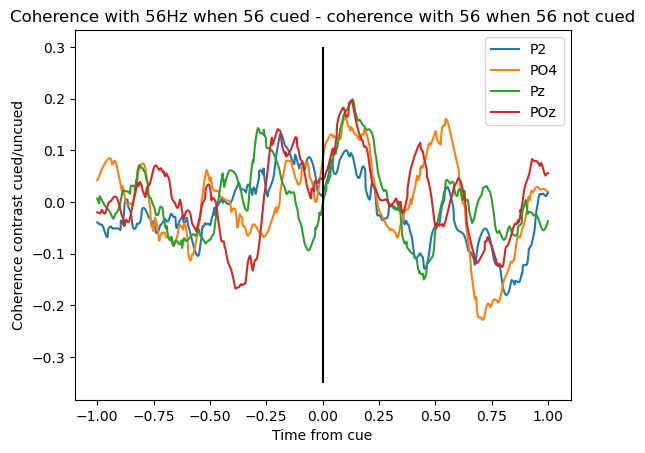

In [27]:
plt.plot(times_coh, coherence_with56_for56cued_top4ch.T - coherence_with56_for60cued_top4ch.T, label = best_electrodes_coherence)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 56Hz when 56 cued - coherence with 56 when 56 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

????? il semble qu il n y ait d effet attentionnel. En meme t il ne pouvait pas y avoir de target avant 1s et c etait sur car meme pas les gabor presents.

# B. Noise tagging condition
# 1 - Tag presence
## 1.1 Cross-correlation

In [28]:
epochs_noistag = epochs['tagging_type==1'].copy()

f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

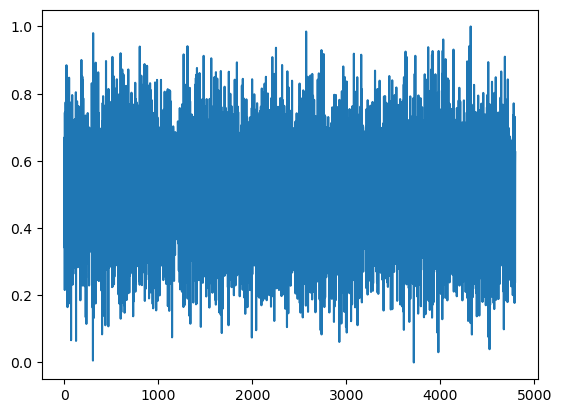

In [29]:
# First noise tag at block 15 trial 32
plt.plot(noise_stims[14,31,0,:].T)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [30]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)
noise_stims_tr = {'trial_number':np.arange(noise_stims_tr.shape[0]), 'data':noise_stims_tr}

#check if the number of retained noises trials is the same as the number of good epochs
sum(np.isin(noise_stims_tr['trial_number'], epochs.metadata['trial_number'])) == len(epochs.metadata['trial_number'])

True

In [31]:
noise_stims_tr['data'].shape

(480, 2, 4800)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
/tmp/ipykernel_8437/4060251728.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_tags = noise_tags['data'][np.isin(noise_tags['trial_number'], selection),:,:int(last_samp-time0)]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
/tmp/ipykernel_8437/4060251728.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_tags = noise_tags['data'][np.isin(noise_tags['trial_number'], selection),:,:int(last_samp-time0)]


Text(0, 0.5, 'Cor EEG/tag')

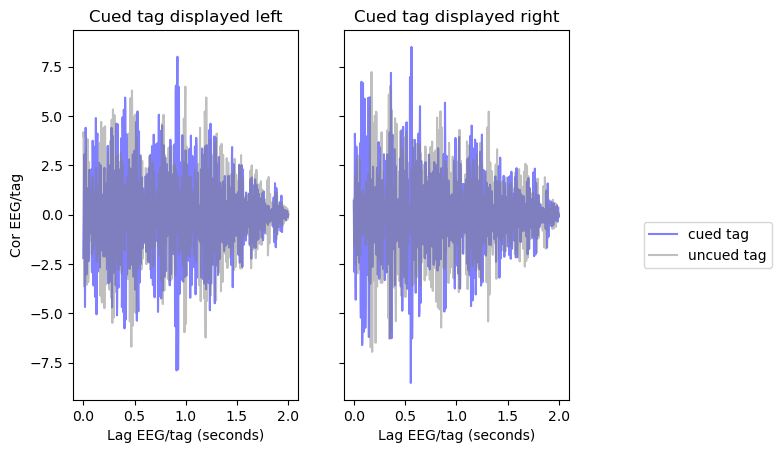

In [32]:
# Get cross-correlation 
def cross_cor_nois(epochs, noise, display_side_cued_tag, sampling_freq, electrodes=None,
                  tmin=0, tmax=1):
    '''
    noise_tags : array trial*tag*timepoint
    display_side_cued_tag : 'left' or 'right'
    sampling_freq : 1920 or 480(Hz)
    
    Returns 2 matrices (trial*electrode*lag (in time steps between EEG start and tag start) of corr values. 
    The first matrice contains the EEG/cued_tag corr, the second the EEG/tag2 corr
    '''
    display_side_cued_tag = 0 if display_side_cued_tag == 'left' else \
        (1 if display_side_cued_tag == 'right' else ValueError("Invalid value for display_side_cued_tag"))

    # Select elec
    if electrodes is None : 
        eeg = epochs.copy()
    else : eeg = epochs.copy().pick_channels(electrodes)
    noise_tags = copy.deepcopy(noise)
    # Converge EEG and tag sampling frequencies 
    if sampling_freq == 1920:
            eeg.resample(sfreq = sampling_freq)
            # Upsample tag from 480 to 1920Hz (by repetition rather than inference)
            noise_tags['data'] = np.repeat(noise_tags['data'], 4, axis=2)
    
    elif sampling_freq == 480:
        eeg.resample(sfreq = sampling_freq)
    
    else : raise ValueError('Sampling frequency must be 1920 or 480Hz')
    
    
    # bandpass (60-80Hz) EEG data + crop from tmin to tmax
    eeg.filter(l_freq=60, h_freq = 80).crop(tmin, tmax)

    time0 = eeg.time_as_index(0)
    last_samp = eeg.times.size - 1
    
    selection = eeg[f'cued_side == {display_side_cued_tag}'].selection
    eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data(copy=False)

    # Select the tags on the same trials as the EEG and only the part that was displayed during the epoch
    noise_tags = noise_tags['data'][np.isin(noise_tags['trial_number'], selection),:,:int(last_samp-time0)] 

    # Loop over trials and electrodes to fill correlation matrices
    cross_corr_tag1 = np.zeros(eeg_arr.shape)
    cross_corr_tag2 = np.zeros(eeg_arr.shape)
    
    for trial in range(eeg_arr.shape[0]):
        for elec in range(eeg_arr.shape[1]):
            # Standardize eeg trial data and noise
            trial_data = (eeg_arr[trial,elec,:]-eeg_arr[trial,elec,:].mean())/eeg_arr[trial,elec,:].std()
            trial_cuednoise = (noise_tags[trial,display_side_cued_tag,:]-noise_tags[trial,display_side_cued_tag,:].mean())\
                        /noise_tags[trial,display_side_cued_tag,:].std()
            trial_noncuednoise = (noise_tags[trial,1-display_side_cued_tag,:]-noise_tags[trial,1-display_side_cued_tag,:].mean())\
                        /noise_tags[trial,1-display_side_cued_tag,:].std()
            # Assume the tag can only appear in the EEG when its screen display has started (crop the first tag_length-1 outputs)
            cross_corr_tag1[trial, elec] = scipy.signal.correlate(trial_data, trial_cuednoise, \
                                                        mode='full')[len(trial_cuednoise)- 1:]
            cross_corr_tag2[trial, elec] = scipy.signal.correlate(trial_data, trial_noncuednoise, \
                                                        mode='full')[len(trial_noncuednoise)- 1:]
    return cross_corr_tag1, cross_corr_tag2, selection, eeg.times


sfreq = 480
tmin, tmax = 0, 2

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = best_electrodes_coherence,\
    sampling_freq = sfreq, tmin=tmin, tmax=tmax)
cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes = best_electrodes_coherence,\
    sampling_freq = sfreq, tmin=tmin, tmax=tmax)

# store concatenated crosscorrelations in the same order as the trials
trials_noise_tag = np.concatenate([idx_cuedR,idx_cuedL])
corr_with_cued_arr = np.concatenate([cor_with_cued_for_cuedR, cor_with_cued_for_cuedL])[np.argsort(trials_noise_tag)]
corr_with_uncued_arr = np.concatenate([cor_with_uncued_for_cuedR, cor_with_uncued_for_cuedL])[np.argsort(trials_noise_tag)]

# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times, cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times, cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(times, cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(times, cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')


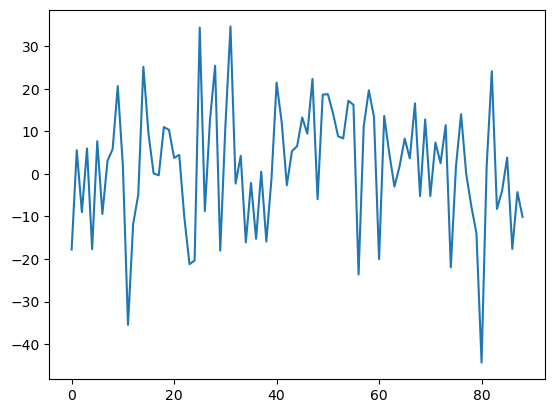

In [33]:
plt.plot(np.mean(cor_with_cued_for_cuedR.max(axis=(2))-cor_with_uncued_for_cuedR.max(axis=(2)), axis=1))

/tmp/ipykernel_8437/1589699224.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


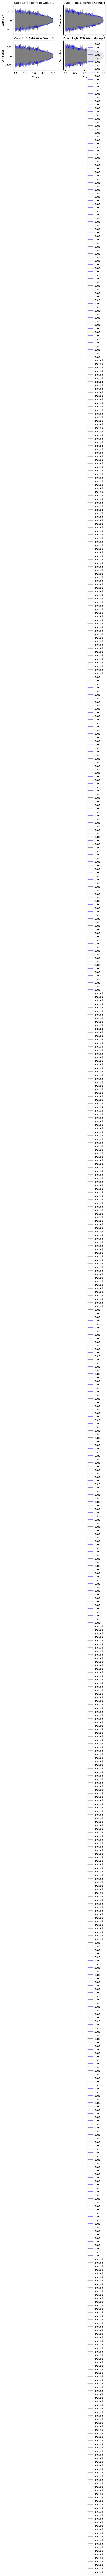

In [34]:

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)
axes = ax.flatten()

# Titles for the subplots
titles = ['Cued Left Electrode Group 1', 'Cued Right Electrode Group 1', 
          'Cued Left Electrode Group 2', 'Cued Right Electrode Group 2']

# Data arrays
data_arrays = [
    (cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL),
    (cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR),
    (cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL),
    (cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR)
]

# Plot each electrode group
for ax, title, (cued_data, uncued_data) in zip(axes, titles, data_arrays):
    for i in range(cued_data.shape[1]):
        ax.plot(times, cued_data[:, i, :].T, color='blue', label='cued', alpha=.5)
        ax.plot(times, uncued_data[:, i, :].T, color='grey', label='uncued', alpha=.5)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Correlation')

# Add a legend to the last subplot
axes[-1].legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Cor EEG/tag')

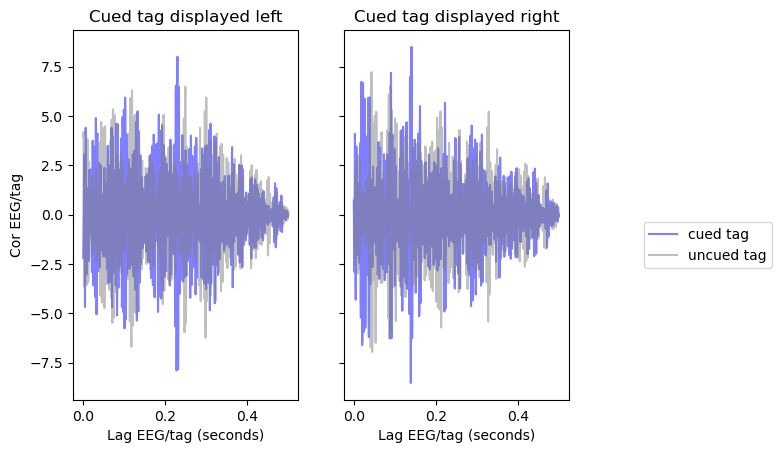

In [35]:
# Plot
x_vals = np.arange(cor_with_cued_for_cuedR.shape[-1])*(1/1920)
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(x_vals, cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(x_vals, cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(x_vals, cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(x_vals, cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')


Text(0, 0.5, 'Cor EEG/tag')

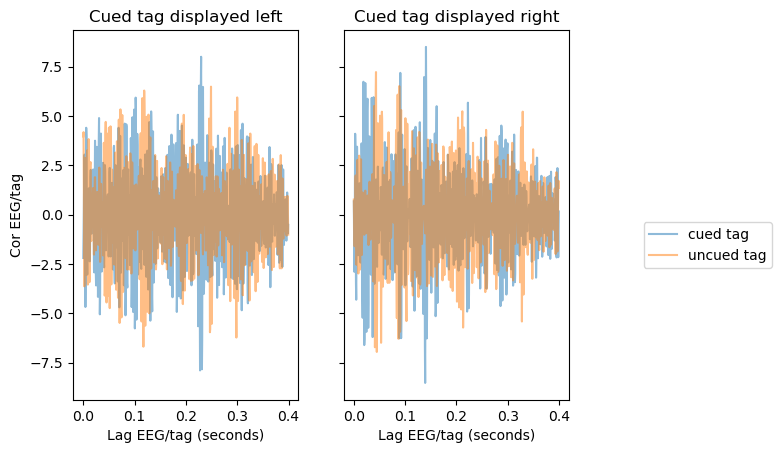

In [36]:
# Plot for lag EEG/tag up to 400ms
x_vals = np.arange(cor_with_cued_for_cuedR.shape[-1])*(1/1920)
x_vals = x_vals[:768]
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(x_vals, cor_with_cued_for_cuedL[:,:,:768].mean(axis=(0,1)).T, alpha=.5)
ax[0].plot(x_vals, cor_with_uncued_for_cuedL[:,:,:768].mean(axis=(0,1)).T, alpha=.5)

ax[1].plot(x_vals, cor_with_cued_for_cuedR[:,:,:768].mean(axis=(0,1)).T, label='cued tag', alpha=.5)
ax[1].plot(x_vals, cor_with_uncued_for_cuedR[:,:,:768].mean(axis=(0,1)).T, label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

In [37]:
print(generate_freq_tag(60).min()) #????? pas les mm range freq vs noise -> par meme range de cor
print(generate_freq_tag(60).max())
print(generate_freq_tag(60).mean())

NameError: name 'generate_freq_tag' is not defined

## 2.2 Prediction

In [ ]:
# Average the correlation over electrodes
uncued_R = np.mean(cor_with_uncued_for_cuedL, axis=1)
cued_R = np.mean(cor_with_cued_for_cuedR, axis=1)
uncued_L = np.mean(cor_with_uncued_for_cuedR, axis=1)
cued_L = np.mean(cor_with_cued_for_cuedL, axis=1)

# Get the correlation difference between left and right tag 
# (not cued - uncued since goal is to apply when we don't know where attention was)
diffLR_cueR = uncued_L - cued_R
diffLR_cueL = cued_L - uncued_R

In [ ]:
# Keep only the first timepoints to reduce dimensionality
samplping_freq = 480
diffLR_cueR = diffLR_cueR[:,:int(0.5*samplping_freq)]
diffLR_cueL = diffLR_cueL[:,:int(0.5*samplping_freq)]

# Build data frame for classification
df_cor_nois = pd.DataFrame({f'diff_LR_timepoint_{i+1}': [] for i in range(diffLR_cueR.shape[1])})

for trial in range(diffLR_cueR.shape[0]):
    df_cor_nois.loc[trial, :] = diffLR_cueR[trial,:]

for trial in range(diffLR_cueL.shape[0]):
    trial_df = trial + diffLR_cueR.shape[0] 
    df_cor_nois.loc[trial_df, :] = diffLR_cueL[trial,:]

df_cor_nois['cue_side'] = np.repeat([1, 0], [diffLR_cueR.shape[0], diffLR_cueL.shape[0]])


In [ ]:
import sklearn.model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Train-test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_cor_nois.iloc[:,:-1],df_cor_nois.iloc[:,-1], test_size=0.2, random_state=0)


# Define the LDA model, parameter grid and evaluation metrics
lda = LinearDiscriminantAnalysis()

param_grid = [
  {'solver': ['lsqr', 'eigen'],'shrinkage': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0]},
  {'solver': ['svd']},]

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Set up GridSearchCV with 5 fold CV
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, scoring= scoring, refit="AUC", return_train_score=True,)

# Fit the model
grid_search.fit(X_train, y_train)

In [ ]:
results = grid_search.cv_results_
# Evaluate the best model
best_lda = grid_search.best_estimator_

# Predict on the test set
y_pred = best_lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

In [ ]:
temp_cueR = uncued_L - cued_R
temp_cueL = cued_L - uncued_R

X = np.vstack((temp_cueR, temp_cueL))
y = np.repeat([1, 0], [temp_cueR.shape[0], temp_cueL.shape[0]])

In [ ]:
noise_stims_tr[:,:,:diffLR_cueR.shape[-1]].shape 

In [ ]:
# # Diff L/R not averaged over electrodes
# LdiffR_cueR = cor_with_uncued_for_cuedR - cor_with_cued_for_cuedR
# LdiffR_cueL = cor_with_cued_for_cuedL - cor_with_uncued_for_cuedL

# X = np.vstack((LdiffR_cueR, LdiffR_cueL))
# y = np.repeat([1, 0], [diffLR_cueR.shape[0], diffLR_cueL.shape[0]])

# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_test.shape

In [ ]:
# X_train.to_csv(f'{data_path}/X_train.csv', index=False)
# X_test.to_csv(f'{data_path}/X_test.csv', index=False)
# y_train.to_csv(f'{data_path}/y_train.csv', index=False)
# y_test.to_csv(f'{data_path}/y_test.csv', index=False)

In [ ]:
epochs_noistag[f'cued_side == 0'].metadata['trial_number']


In [ ]:
R = epochs_noistag[f'cued_side == 1'].selection
R = np.concatenate([R,[1000]])
R

In [ ]:
L = epochs_noistag[f'cued_side == 0'].selection
L

In [ ]:
ind_L = 0
ind_R = 0
tag_index = []
for i in range(219):
    if ind_R < len(R) & ind_L < len(L):
        if L[ind_L] < R[ind_R] :
            tag_index.append('L')
            ind_L += 1
        else: 
            tag_index.append('R')
            ind_R += 1
    elif ind_R == len(R) :
        print('stop R')
    elif ind_L == len(L) :
        print('stop L')
        
        

In [ ]:
print(tag_index)

In [ ]:
indexes = [i for i, value in enumerate(tag_index) if value == 'L']

In [ ]:
print(indexes)

In [ ]:
len(L)